In [1]:
# Run this again after editing submodules so Colab uses the updated versions

from copy import deepcopy
from citylearn import CityLearn
from pathlib import Path

from TD3 import TD3 as Agent

import sys
import warnings
import utils
import time

import numpy as np
import pandas as pd

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load environment
climate_zone = 5
params = {
    "data_path": Path("data/Climate_Zone_" + str(climate_zone)),
    "building_attributes": "building_attributes.json",
    "weather_file": "weather_data.csv",
    "solar_profile": "solar_generation_1kW.csv",
    "carbon_intensity": "carbon_intensity.csv",
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "simulation_period": (0, 8760 * 4 - 1),
    "cost_function": [
        "ramping",
        "1-load_factor",
        "average_daily_peak",
        "peak_demand",
        "net_electricity_consumption",
        "carbon_emissions",
    ],
    "central_agent": False,
    "save_memory": False,
}

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

# Parameters for the agent
params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

In [2]:
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()


params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

# Instantiating the control agent(s)
# agents = Agent(**params_agent)
RBC_THRESHOLD = 48  # 2 weeks
agents = Agent(
    num_actions=actions_spaces,
    num_buildings=len(observations_spaces),
    env=env,
    rbc_threshold=RBC_THRESHOLD,
)


# Initialising the simulation for all the agents
state = env.reset()
done = False

action = agents.select_action(state)

t_idx = 0
# run for a month - NOTE: THIS WILL TAKE ~2 HOURS TO RUN. reduce `end_time` for quicker results.
end_time = RBC_THRESHOLD + 24 * 7

start_time = time.time()

costs_peak_net_ele = []

# returns E_grid for RBC agent
E_grid_RBC = utils.RBC(actions_spaces).get_rbc_data(
    deepcopy(env), state, utils.get_idx_hour(), end_time)

E_grid_true = []  # see comments below for more info.

while not done and t_idx <= end_time:

    ## add env E-grid
    E_grid_true.append([x[28] for x in state])

    next_state, reward, done, _ = env.step(action)
    action_next = agents.select_action(
        next_state, env
    )  # passing in environment for Oracle agent.

    agents.add_to_buffer_oracle(env, action, reward)
    # agents.add_to_buffer(state, action, reward, next_state, done)
    state = next_state
    action = action_next

    t_idx += 1

    print(f"\rTime step: {t_idx}", end="")

print(
    f"Total time (min) to run {end_time // 24} days of simulation: {round((time.time() - start_time) / 60, 3)}"
)

Time step: 95
Time taken (min): 13.866
Time step: 143
Time taken (min): 14.738
Time step: 191
Time taken (min): 14.748
Time step: 217Total time (min) to run 9 days of simulation: 44.549


In [93]:
# Running RBC agent to get actions
from utils import RBC

# Instantiating the control agent(s)
# agents = Agent(**params_agent)
RBC_THRESHOLD = 48  # 2 weeks

# Initialising the simulation for all the agents
state = env.reset()
done = False

action = utils.RBC(actions_spaces).select_action(state)

t_idx = 0
# run for a month - NOTE: THIS WILL TAKE ~2 HOURS TO RUN. reduce `end_time` for quicker results.
end_time = RBC_THRESHOLD + 24 * 7

RBC_actions_arr = []

start_time = time.time()

costs_peak_net_ele = []

while not done and t_idx <= end_time:
    
    
    next_state, reward, done, _ = env.step(action)
    
    action_next = utils.RBC(actions_spaces).select_action(next_state)
  # passing in environment for Oracle agent.

    RBC_actions_arr.append(np.array(action))
    
    state = next_state
    action = action_next

    t_idx += 1

    print(f"\rTime step: {t_idx}", end="")

print(
    f"Total time (min) to run {end_time // 24} days of simulation: {round((time.time() - start_time) / 60, 3)}"
)




Time step: 529Total time (min) to run 22 days of simulation: 0.07


In [94]:
print(np.shape(RBC_actions_arr))
RBC_actions_arr = np.array(RBC_actions_arr)
print(RBC_actions_arr[:,:,1])
print(np.shape(RBC_actions_arr[:,:,1]))

(529, 9, 3)
[[0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]
 [0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]
 [0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]
 ...
 [0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]
 [0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]
 [0.05532000000000001 0.05532000000000001 0.05532000000000001 ...
  0.05532000000000001 0.05532000000000001 0.05532000000000001]]
(529, 9)


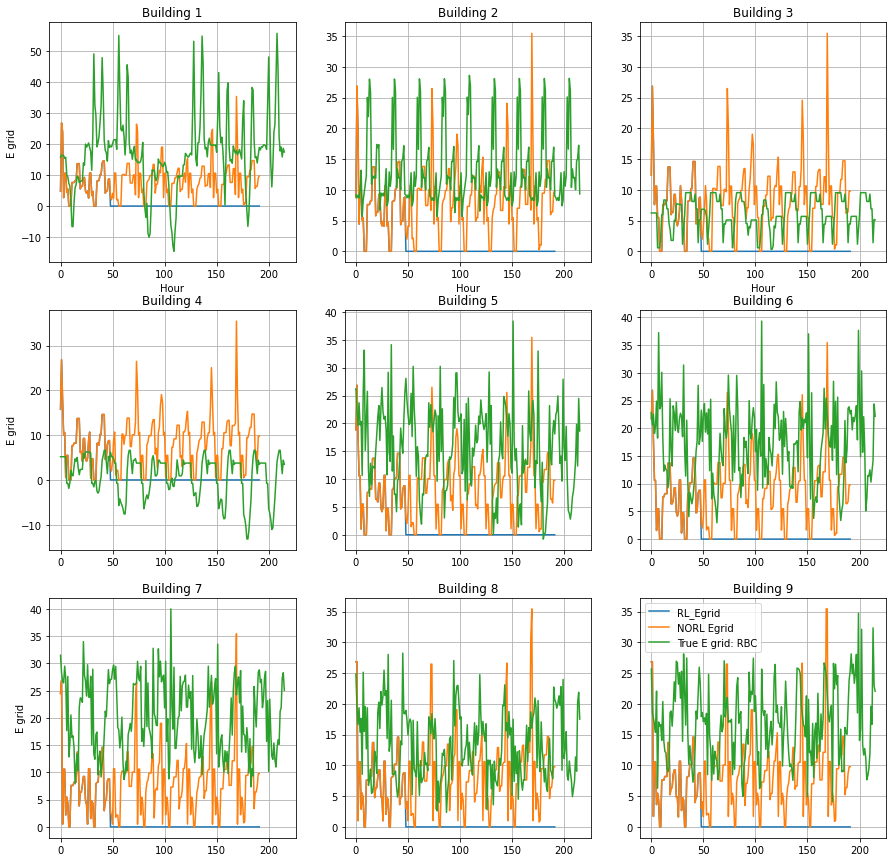

In [39]:
############## TODO: ENTER CODE HERE ##############

# list of dictionary of variables generated from RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
# NOTE: dimensions of RL/NORL logger is ≠ RBC. This is because RL/NORL implicitly uses RBC. We only start collecting data from
# RL/NORL once it starts making inference, i.e, after `rbc_threshold`. Tweak the parameter above!

vars_RL = agents.logger

# list of dictionary of variables generated NORL - Optim w/o any RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
vars_NORL = agents.norl_logger

# true E-grid values. NOTE: E_grid = E_grid_true. E_grid_pred = var["E_grid"] for RL/Optim
E_grid_true = np.array(E_grid_true)

# E_grid net electricity consumption per building using RBC
E_grid_RBC = np.array(E_grid_RBC)

############## TODO: ENTER CODE HERE ##############


# vars_RL = np.array(vars_RL)  # DImension - No.of days
# RL_SOC_C = np.flatten(vars_RL[:]['SOC_C']).reshape(24*30,9)
# RL_SOC_C.append(vars_RL[i]['SOC_C'])

# #If indexing error, use the for loop
# RL_SOC_C.append( vars_RL[i][key] )
# RL_SOC_C = np.array(RL_SOC_C).flatten().reshape(days * 24, 9)


# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # RL
# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # NORL  #Already Defined

# 1. RBC Agent
RBC_actions_arr = []
RBC_look_ahead_cost = []  
RBC_E_grid_pred = []
RBC_E_grid_sell = []
RBC_E_hpC = []
RBC_E_ehH = []
RBC_Edhw = []
RBC_SOC_bat = []
RBC_SOC_C = []
RBC_SOC_H = []
RBC_C_p_bat = []
RBC_C_p_Csto = []
RBC_C_p_Hsto = []
RBC_ramping_cost = []
RBC_peak_electricity_cost = []
RBC_total_cost = []
RBC_action_C = []
RBC_action_H = []
RBC_action_bat = []

# 2. RL Agent
RL_actions_arr = []
RL_look_ahead_cost = [] 
RL_E_grid_sell = []
RL_E_grid_pred = []
RL_E_hpC = []
RL_E_ehH = []
RL_Edhw = []
RL_SOC_bat = []
RL_SOC_H = []
RL_SOC_C = []
RL_C_p_bat = []
RL_C_p_Csto = []
RL_C_p_Hsto = []
RL_ramping_cost = []
RL_peak_electricity_cost = []
RL_total_cost = []
RL_action_C = []
RL_action_H = []
RL_action_bat = []

# 3. NO RL Agent (Just Optimization)
NORL_actions_arr = []
NORL_look_ahead_cost = []
NORL_E_grid_sell = []
Egrid = []  
NORL_E_grid_pred = []
NORL_E_hpC = []
NORL_E_ehH = []
NORL_Edhw = []
NORL_SOC_bat = []
NORL_SOC_C = []
NORL_SOC_H = []
NORL_C_p_bat = []
NORL_C_p_Csto = []
NORL_C_p_Hsto = []
NORL_ramping_cost = []
NORL_peak_electricity_cost = []
NORL_total_cost = []
NORL_action_C = []
NORL_action_H = []
NORL_action_bat = []


# keys = list("E_grid", "E_grid_sell", "E_hpC", "E_ehH", "SOC_bat", "SOC_H", "SOC_C", " action_bat", "action_H", "action_C") 



for i in range(len(vars_RL)): #number of days of RL/NORL
    for j in range (9):
        RL_E_grid_pred.append(vars_RL[i][j]["E_grid"])
        RL_E_grid_sell.append(vars_RL[i][j]["E_grid_sell"])
        RL_E_hpC.append(vars_RL[i][j]["E_hpC"])
        RL_E_ehH.append(vars_RL[i][j]['E_ehH'])
        RL_SOC_bat.append(vars_RL[i][j]["SOC_bat"])
        RL_SOC_H.append(vars_RL[i][j]["SOC_H"])
        RL_SOC_C.append(vars_RL[i][j]["SOC_C"])
        RL_action_bat.append(vars_RL[i][j]["action_bat"])
        RL_action_C.append(vars_RL[i][j]["action_C"])
        RL_action_H.append(vars_RL[i][j]["action_H"])
        
    
        NORL_E_grid_pred.append(vars_NORL[i][j]["E_grid"])
        NORL_E_grid_sell.append(vars_NORL[i][j]["E_grid_sell"])
        NORL_E_hpC.append(vars_NORL[i][j]["E_hpC"])
        NORL_E_ehH.append(vars_NORL[i][j]["E_ehH"])
        NORL_SOC_bat.append(vars_NORL[i][j]["SOC_bat"])
        NORL_SOC_H.append(vars_NORL[i][j]["SOC_H"])
        NORL_SOC_C.append(vars_NORL[i][j]["SOC_C"])
        NORL_action_bat.append(vars_NORL[i][j]["action_bat"])
        NORL_action_C.append(vars_NORL[i][j]["action_C"])
        NORL_action_H.append(vars_NORL[i][j]["action_H"])

# ### flatten out to get hour per building

RL_E_grid_pred = np.array(RL_E_grid_pred).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_E_grid_sell = np.array(RL_E_grid_sell).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_E_hpC = np.array(RL_E_hpC).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_E_ehH = np.array(RL_E_ehH).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_SOC_bat = np.array(RL_SOC_bat).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_SOC_H = np.array(RL_SOC_H).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_SOC_C = np.array(RL_SOC_C).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_action_bat = np.array(RL_action_bat).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_action_C = np.array(RL_action_C).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings
RL_action_H = np.array(RL_action_H).flatten().reshape(len(vars_RL) * 24, 9) # hours x num_buildings

NORL_E_grid_pred = np.array(NORL_E_grid_pred).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_E_grid_sell = np.array(RL_E_grid_sell).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_E_hpC = np.array(NORL_E_hpC).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_E_ehH = np.array(NORL_E_ehH).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_SOC_bat = np.array(NORL_SOC_bat).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_SOC_H = np.array(NORL_SOC_H).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_SOC_C = np.array(NORL_SOC_C).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_action_bat = np.array(NORL_action_bat).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_action_C = np.array(NORL_action_C).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings
NORL_action_H = np.array(NORL_action_H).flatten().reshape(len(vars_NORL) * 24, 9) # hours x num_buildings



# plot predicted E_grid
# week = end_time - 24 * 3  # plots last week of the month data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_E_grid_pred[:,i*3+j], label="RL_Egrid"
        )  
        axs[i, j].plot(
            NORL_E_grid_pred[:,i*3+j],
            label="NORL Egrid",
        )  # plots per month
        axs[i, j].plot(
            E_grid_RBC[:,i*3+j], label="True E grid: RBC"
        )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("E grid")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()


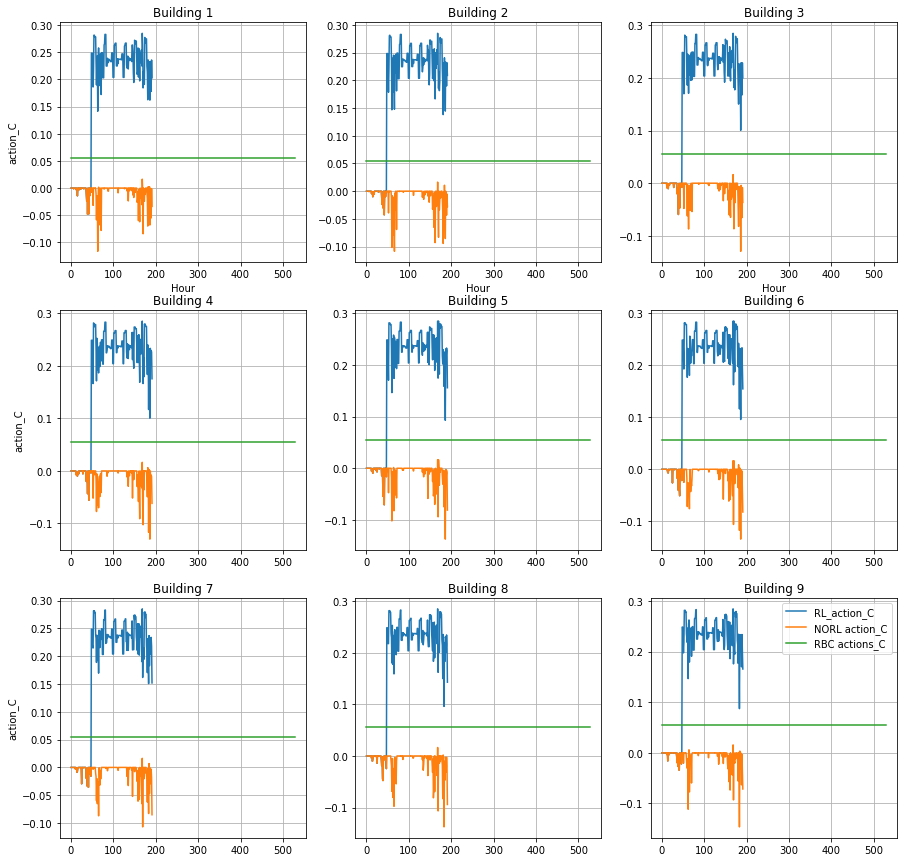

In [95]:
# plot action_C
# week = end_time - 24 * 3  # plots last week of the month data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_action_C[:,i*3+j], label="RL_action_C"
        )  
        axs[i, j].plot(
            NORL_action_C[:,i*3+j],
            label="NORL action_C",
        )  # plots per month
        axs[i, j].plot(
             RBC_actions_arr[:,i*3+j,0], label="RBC actions_C"
         )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("action_C")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()


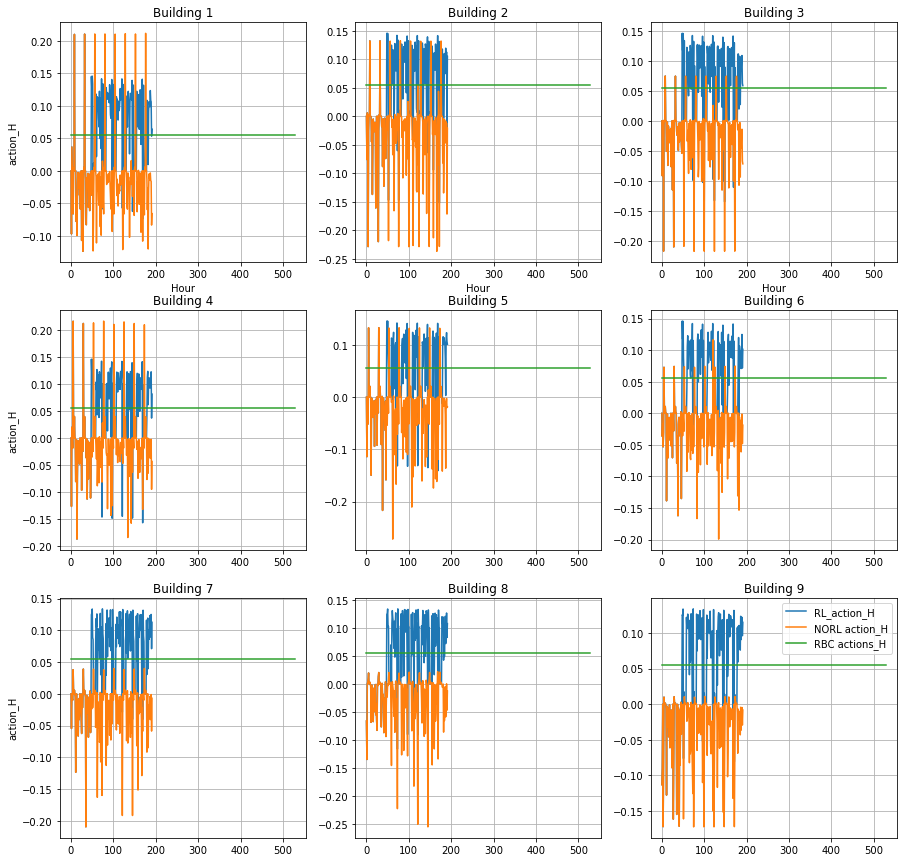

In [96]:
# plot action_H
# week = end_time - 24 * 3  # plots last week of the month data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_action_H[:,i*3+j], label="RL_action_H"
        )  
        axs[i, j].plot(
            NORL_action_H[:,i*3+j],
            label="NORL action_H",
        )  # plots per month
        axs[i, j].plot(
             RBC_actions_arr[:,i*3+j,1], label="RBC actions_H"
         )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("action_H")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()

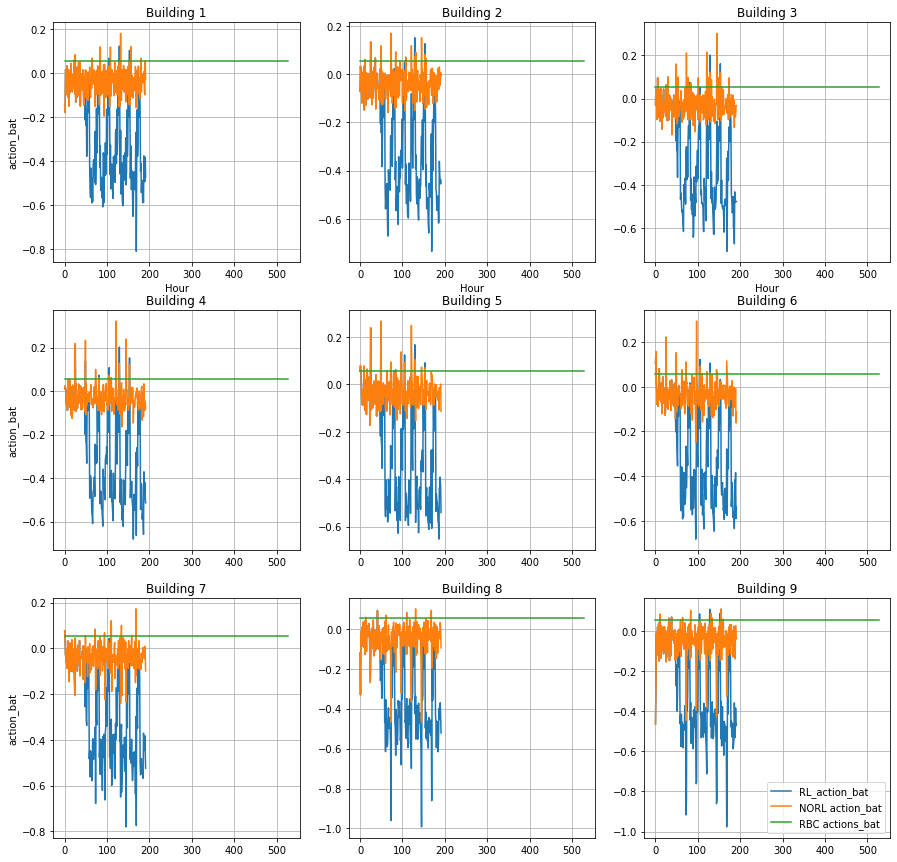

In [97]:
# plot action_bat
# week = end_time - 24 * 3  # plots last week of the month data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_action_bat[:,i*3+j], label="RL_action_bat"
        )  
        axs[i, j].plot(
            NORL_action_bat[:,i*3+j],
            label="NORL action_bat",
        )  # plots per month
        axs[i, j].plot(
             RBC_actions_arr[:,i*3+j,2], label="RBC actions_bat"
         )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("action_bat")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()

In [4]:
agents.E_grid_planned_day.shape

(9, 24)

In [22]:
vars_RL = agents.logger
print(np.shape(vars_RL))

vars_NORL = agents.norl_logger

RL_E_grid_pred = []




for i in range(len(vars_RL)): #number of days of RL/NORL
    for j in range(9):
        RL_E_grid_pred.append(vars_RL[i][j]["E_grid"])
        
   
    
RL_E_grid_pred = np.array(RL_E_grid_pred).flatten().reshape(len(vars_RL) * 24, 9)

print(np.shape(RL_E_grid_pred))
print(RL_E_grid_pred)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_E_grid_pred[:,i*3+j], label="RL_Egrid"
        )  
#         axs[i, j].plot(
#             NORL_Egrid_pred[:,i*3+j],
#             "gx",
#             label="NORL Egrid",
#         )  # plots per month
#         axs[i, j].plot(
#             RBC_Egrid[bid][week:], label="True E grid: RBC"
#         )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("E grid")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()



(8, 9)


NameError: name 'RL_E_grid_sell' is not defined

### Plotting

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
### TODO: insert code here

### plot
# plt.plot(vars_A_RL[:, 0])
# plt.plot(vars_A_NORL[:, 0])
# plt.plot(vars_A_RBC[:, 0])

In [ ]:
rewards = np.zeros(shape=(7, 24, 9)) # days, hours, buildings
for i, day in enumerate(agents.memory.replay_memory):
    _reward = np.array(day["reward"])
    rewards[i] = _reward
rewards = rewards.reshape((7 * 24, 9))

In [ ]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(3, 3, figsize=(15, 15)) # 9 buildings

id = 0
for r in range(3):
    for c in range(3):
        axs[r, c].plot(rewards[:, id])
        axs[r, c].set_title(f"Building {id + 1}")
        id += 1
        
# set labels
plt.setp(axs[-1, :], xlabel='Hour')
plt.setp(axs[:, 0], ylabel='Reward')

plt.show()

In [2]:
import torch
from platform import python_version
print(torch.__version__)
print(python_version())

1.6.0
3.7.3
